In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, norm
from numpy.random import normal
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invgamma, bernoulli
import math

In [41]:
x = np.random.uniform(-5,5,200)
x.sort()

x_ones = np.ones(shape=(len(x),2))
x_ones[:,0] = x

mean = np.zeros(len(x))

In [46]:
#Fill in Gram matrix
K_RBF = np.zeros(shape=(len(x),len(x)))
gamma = 0.1
alpha = 1

K_POLY = np.zeros(shape=(len(x),len(x)))

K_NN = np.zeros(shape=(len(x),len(x)))
sigma_NN = np.array([[10,0],[0,1]])

for i in range(len(x)):
    for j in range(len(x)):
        K_RBF[i,j] = alpha*np.exp(-gamma*(x[i]-x[j])**2)
        K_POLY[i,j] = (1+ x[i]*x[j])**2
        K_NN[i,j] = 2/np.pi * math.asin((2*x_ones[i]@sigma_NN@x_ones[j].T)
                                         /np.sqrt((1+2*x_ones[i]@sigma_NN@x_ones[i].T)*(1+2*x_ones[j]@sigma_NN@x_ones[j].T)))

K_RBF = K_RBF + 1e-6*np.eye(len(x))
K_POLY = K_POLY + 1e-6*np.eye(len(x))
K_NN = K_NN + 1e-6*np.eye(len(x))

In [14]:
q = x_ones[0] @ sigma_NN
q @ x_ones[0]

59.143284758593275

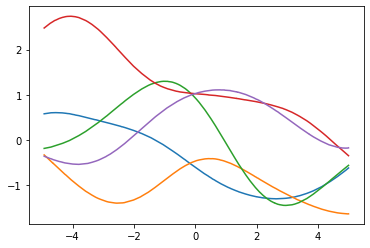

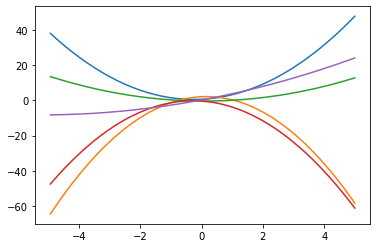

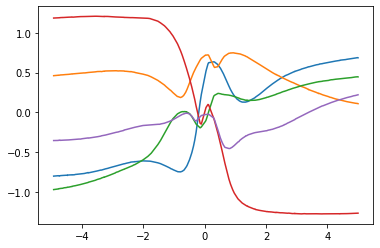

In [47]:
for i in range(5):
    f = multivariate_normal.rvs(mean, K_RBF)
    plt.plot(x, f)
plt.show()

for i in range(5):
    f = multivariate_normal.rvs(mean, K_POLY)
    plt.plot(x, f)
plt.show()

for i in range(5):
    f = multivariate_normal.rvs(mean, K_NN)
    plt.plot(x, f)
plt.show()

In [64]:
x_test = normal(size=(20))
x_test.sort()
y_test = np.array([1 if x_test[i] > 0 else 0 for i in range(len(x_test))])

K = np.zeros(shape=(len(x_test),len(x_test)))
gamma = 10
alpha = 1
for i in range(len(x_test)):
    for j in range(len(x_test)):
        K[i,j] = alpha*np.exp(-gamma*(x_test[i]-x_test[j])**2)
              
invK = inv(K)
cov_f = inv(invK + np.eye(len(x_test)))

In [24]:
z = normal(size=len(x_test))
z = np.array([z[i] - 2 if y_test[i] == 0 else z[i] + 2 for i in range(len(z))])

S = 1000
allF = np.zeros((S, len(x_test)))
allZ = np.zeros((S, len(x_test)))
points = []
#Gibbs sampler
for s in range(S):
    # Update f
    f = multivariate_normal.rvs(cov_f @ z,cov_f)
    allF[s] = f
    # Update y (using rejection sampling)
    for n in range(len(x_test)):
        finished = False
        while not finished:
            z[n] = normal() + f[n]
            if z[n]*(2*y_test[n]-1) > 0:
                finished = True
    allZ[s] = z
    points.append(s)

In [70]:
z = np.ones(len(x_test))
# z = np.array([z[i] - 2 if y_test[i] == 0 else z[i] + 2 for i in range(len(z))])
z = np.array([1 if y_test[i] == 0 else 1 for i in range(len(z))])

S = 1000
allF = np.zeros((S, len(x_test)))
allZ = np.zeros((S, len(x_test)))
allV = np.zeros(S)
allY = np.zeros((S, len(x_test)))
points = []
v = invgamma.rvs(2,scale=2)
#Gibbs sampler
for s in range(S):
    # Update f
    cov = inv(invK/v + np.eye(len(x_test)))
    f = multivariate_normal.rvs(cov @ z,cov)
    allF[s] = f
    
    # Update v
    a = 2 + len(x_test)/2
    b = (f.T @ invK @ f + 4)/2 #check dimensions
    v = invgamma.rvs(a, scale=b)
    allV[s] = v   
    
    # Update z (using rejection sampling)
    for n in range(len(x_test)):
        finished = False
        while not finished:
            z[n] = normal() + f[n]
            if z[n]*(2*y_test[n]-1) > 0:
                finished = True
    allZ[s] = z
    points.append(s)
    
    t_star = np.array([1 if z[i] > 0 else 0 for i in range(len(z))])
    allY[s] = t_star

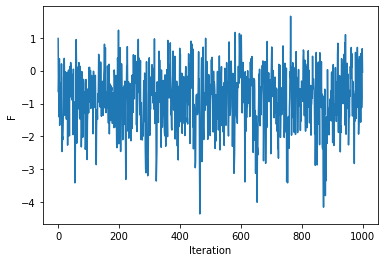

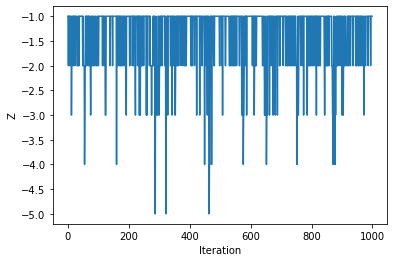

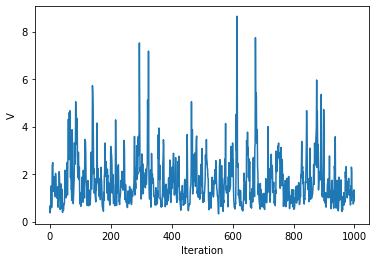

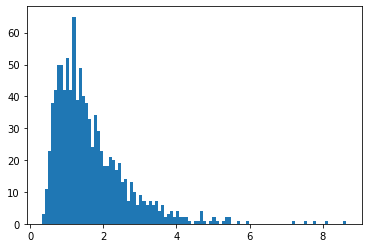

In [71]:
plt.plot(points, allF[:,0])
plt.xlabel("Iteration")
plt.ylabel("F")
plt.show()

plt.plot(points, allZ[:,0])
plt.xlabel("Iteration")
plt.ylabel("Z")
plt.show()

plt.plot(points, allV)
plt.xlabel("Iteration")
plt.ylabel("V")
plt.show()
plt.hist(allV, bins=100)
plt.show()


In [77]:
data = pd.read_csv("data/train.csv")
data_test = pd.read_csv("data/testX.csv")

y_train = np.expand_dims(data['y'], axis=1)
x_train = data.drop('y', axis=1).to_numpy()

x_test = data_test.to_numpy()

K = np.zeros(shape=(len(x_train),len(x_train)))
R = np.zeros(shape=(len(x_train),len(x_test)))
K_STAR = np.zeros(shape=(len(x_test),len(x_test)))

alpha = 1
gamma = 1/2*(len(x_train)*len(x_train[0])/np.sum(norm(x_train,axis=1))) # to do length-scale
for i in range(len(x_train)):
    for j in range(len(x_train)):
        K[i,j] = alpha*np.exp(-gamma*norm(x_train[i]-x_train[j])**2)
        
for i in range(len(x_train)):
    for j in range(len(x_test)):
        R[i,j] = alpha*np.exp(-gamma*norm(x_train[i]-x_test[j])**2)
        
for i in range(len(x_test)):
    for j in range(len(x_test)):
        K_STAR[i,j] = alpha*np.exp(-gamma*norm(x_test[i]-x_test[j])**2)

invK = inv(K)
cov_f = inv(invK + np.eye(len(x_train)))

In [78]:
z = normal(size=len(x_train))
z = np.array([1 if y_train[i] == 0 else 1 for i in range(len(z))])

S = 1000
allF = np.zeros((S, len(x_train)))
allZ = np.zeros((S, len(x_train)))
allFS = np.zeros((S, len(x_test)))
allY = np.zeros((S, len(x_test)))
allV = np.zeros(S)
allPS = np.zeros((S, len(x_test)))

points = []

# Sample first value from the prior
v = invgamma.rvs(2,scale=2)
#Gibbs sampler
for s in range(S):
    # Update f
    # f = multivariate_normal.rvs(cov_f @ z,cov_f)
    cov = inv(invK/v + np.eye(len(x_train)))
    f = multivariate_normal.rvs(cov @ z,cov)
    allF[s] = f
    
    # # Update v
    a = 2 + len(x_train)/2
    b = (f.T @ invK @ f + 4)/2 #check dimensions
    v = invgamma.rvs(a, scale=b)
    allV[s] = v   
    
    # Update y (using rejection sampling)
    for n in range(len(x_train)):
        finished = False
        while not finished:
            z[n] = normal() + f[n]
            if z[n]*(2*y_train[n]-1) > 0:
                finished = True
    allZ[s] = z
    points.append(s)
    
    mu_star = (R.T @ invK @ f)/v
    sigma_star = (K_STAR - R.T @ invK @ R)/v

    f_star = multivariate_normal.rvs(mu_star, sigma_star)
    allFS[s] = f_star
    
    p_star = multivariate_normal.cdf(f_star)
    allPS[s] = p_star
    y_star = bernoulli.rvs(p_star)
    allY[s] = y_star

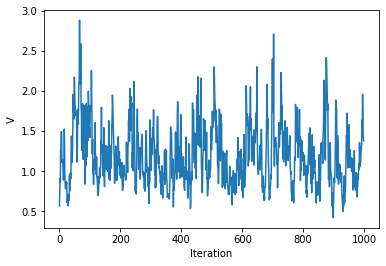

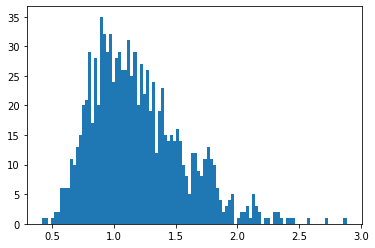

In [50]:
plt.plot(points, allV)
plt.xlabel("Iteration")
plt.ylabel("V")
plt.show()
plt.hist(allV, bins=100)
plt.show()

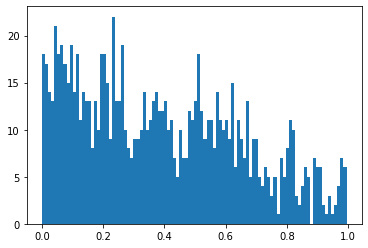

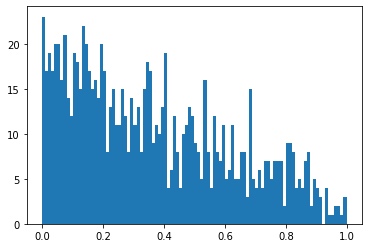

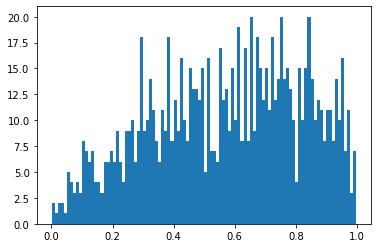

In [79]:
q = np.mean(allY, axis=0)
plt.hist(allPS[:,0], bins=100)
plt.show()
plt.hist(allPS[:,1], bins=100)
plt.show()
plt.hist(allPS[:,16], bins=100)
plt.show()


